# 😒 The problem with the last one
- We created the bigram model **manually**
- We created the **NN model** which learnt the relationships
- We confirmed that **NN has learnt** the relationships **correctly** by setting the same random seed.

The problem was *"the next character that was going to be generated, was **only dependent on the previous** character"*. Thus the new names generated looked *less like* the names.

___

> So, this time we will change the approach a bit, and we will create a **n-gram table** *(which is not bigram - 2 characters)* which takes previous say 3 characters and predicts the next one.

___

### Just kidding.
This **tabular approach** isn't scalable. We can't make the table of every single possible combination for the characters, the size of the table will grow exponentially and... we will give up to this saying *"we can't do this, whole world is a lie".*

Don't ever say that. We have the NNs. So, this time we will use them, and not the table. Table was just to understand the *behind the scenes* thing. They will no longer come in the picture.


In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Before:

<pre>
                 +-------------------+                
                 |                   |                
                 | A Neural Net      |                
                 | Training with     |                
+-----+          | single character  |        +------+
|  E  ------------ in X and single   ----------  M   |
|     |          | character in Y.   |        |      |
+-----+          |                   |        +------+
                 | Learning through  |                
                 | logloss           |                
                 |                   |                
                 +-------------------+                
</pre>

## Now:

<pre>
+-----+                                               
|  E  |                                               
|     |--\       +-------------------+                
+-----+   --\    |                   |                
             -\  | A Neural Net      |                
               --| Training `n`      |                
+-----+          | previous          |        +------+
|  M  |----------- characters X      ----------  A   |
|     |          | to generate next Y|        |      |
+-----+          |                   |        +------+
               --|                   |                
             -/  |                   |                
+-----+   --/    |                   |                
|  M  |--/       +-------------------+                
|     |                                               
+-----+                                               
</pre>

> **NOTE**: As we are building this out, for the simplicity, we will *keep generating* the next single **character**. But the same method can be used for the **word** setting too. That will be done when we will build the GPT. So, hold your self till then ✊

# ♻ A refresher
In the NN setting, how we did everything.

1. We had  **X** and **Y**
2. We encoded the *a-z* into `0-26` (with 27, 28 special tokens)
3. Then one-hot encoded the characters into the length of 27 tensor
4. Fed all characters in one-by-one *(for whole dataaset - not batching used. Just simple)*
5. Calculated the loss
6. Backprop for `n` epochs

Okay, this was the story **till** now. But **from** now we need to **take a different** direction. Because now we are not using the single character to predict next. We will take `3` characters to generate next. *(This can be 4, 5, 1000 any number based upon your understanding of what you are trying to do 😉)*

# 🪕 Bengio
*Not Banjo*!

Ok, sorry Bengio. Here, we will use the technique used in the paper that Bengio wrote. Let's have a look how that goes.

## 🤔 How is this different?
See, now we are progressing towards the "real" stuff. So, whatever we learnt in the past notebooks were basics which helps us understand what is coming next. But from now on we will *keep shifting* gears towards the real-life structure.
___
In the real model training, **we train the model to learn the similarity** between the words. Thus, if you ask the model "dog" and "cat" the similarity will be high, but "dog" and "moon" will have low similarity.

Now, this has to be learnt with **"embeddings"**. 

> **KEY**: Instead of directly passing the encoded values into the network, we will pass the embeddings. The embeddings will be updated later based on the training.

<img src="./Images/NN_Diagram.png">

**Long story short**:
- We will use some kind of **window** of size `3` to generate the next character until the stop token is hit.
- Each of these three character will be of some vector size. We will take `2`. We will call it "embedding".
- We will feed these embeddings, get the generation, calculate the loss, update weights **and also the embeddings**.

Let's see these in action.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# loading the dataset
with open("./names.txt", "r") as file:
    names = file.read().splitlines()

In [4]:
# total unique characters
characters = sorted(list(set(''.join(names))))
characters

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
# Builind index-to-char and char-to-index
number_to_chr = {k:v for k, v in enumerate(["<", ">"] + characters)}
chr_to_number = {v:k for k, v in enumerate(["<", ">"] + characters)}

Let's see how our data will look like.

###  A straight approach, not working code.

In [6]:
# A not working code for the window based operation
block_size = 3

for name in names[:5]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    for i in range(len(name) - block_size):
        print(name[i:i+block_size], "→", name[i+block_size])


--- emma ---
<em → m
emm → a
mma → >

--- olivia ---
<ol → i
oli → v
liv → i
ivi → a
via → >

--- ava ---
<av → a
ava → >

--- isabella ---
<is → a
isa → b
sab → e
abe → l
bel → l
ell → a
lla → >

--- sophia ---
<so → p
sop → h
oph → i
phi → a
hia → >


But this code will fail if the name is less than 3 characters.

In [7]:
# Given a name of just a single character "A".
block_size = 3

for name in ["A"]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    for i in range(len(name) - block_size):
        print(name[i:i+block_size], "→", name[i+block_size])


--- A ---


### Working code
Here we will need to "append" the **special start token** `<` multiple times so that we can suffice any length of names.

In [8]:
# The start of word token has `0` index, okay?
chr_to_number["<"]

0

In [9]:
# Working code
block_size = 3
sot = chr_to_number["<"]

for name in names[:5]:
    window_chars = [sot] * block_size
    print("\n---", name, "---")
    name = name + ">" # removed "<" from the start of the name because added before
    
    for ch in name:
        _3chars = ''.join(
            list(
                map(lambda x:number_to_chr[x], window_chars)
            )) # just converted [0, 0, 0] → [<, <, <] → <<<
        
        print(_3chars, "→", ch)
        ch_index = chr_to_number[ch]
        
        # we will keep updating the last index and shift the ones before that
        # you can use the np.roll() function here as well.
        window_chars = window_chars[1:] + [ch_index]


--- emma ---
<<< → e
<<e → m
<em → m
emm → a
mma → >

--- olivia ---
<<< → o
<<o → l
<ol → i
oli → v
liv → i
ivi → a
via → >

--- ava ---
<<< → a
<<a → v
<av → a
ava → >

--- isabella ---
<<< → i
<<i → s
<is → a
isa → b
sab → e
abe → l
bel → l
ell → a
lla → >

--- sophia ---
<<< → s
<<s → o
<so → p
sop → h
oph → i
phi → a
hia → >


> **NOTE**: If you keep the `block_size=1`, the result will be the same as in the bigram.

## Making the dataset

In [10]:
### MAKING THE DATASET ###
block_size = 3
sot = chr_to_number["<"]

X = []
y = []

for name in names[:5]:
    window_chars = [sot] * block_size
    name = name + ">" # removed "<" from the start of the name because added before
    
    for ch in name:
        _3chars = ''.join(
            list(
                map(lambda x:number_to_chr[x], window_chars)
            )) # just converted [0, 0, 0] → [<, <, <] → <<<
        ch_index = chr_to_number[ch]
        
        X.append(window_chars)
        y.append(ch_index)
        
        # we will keep updating the last index and shift the ones before that
        # you can use the np.roll() function here as well.
        window_chars = window_chars[1:] + [ch_index]

In [11]:
X = torch.tensor(X)
y = torch.tensor(y)

In [12]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  6],
        [ 0,  6, 14],
        [ 6, 14, 14],
        [14, 14,  2],
        [ 0,  0,  0],
        [ 0,  0, 16],
        [ 0, 16, 13],
        [16, 13, 10],
        [13, 10, 23],
        [10, 23, 10],
        [23, 10,  2],
        [ 0,  0,  0],
        [ 0,  0,  2],
        [ 0,  2, 23],
        [ 2, 23,  2],
        [ 0,  0,  0],
        [ 0,  0, 10],
        [ 0, 10, 20],
        [10, 20,  2],
        [20,  2,  3],
        [ 2,  3,  6],
        [ 3,  6, 13],
        [ 6, 13, 13],
        [13, 13,  2],
        [ 0,  0,  0],
        [ 0,  0, 20],
        [ 0, 20, 16],
        [20, 16, 17],
        [16, 17,  9],
        [17,  9, 10],
        [ 9, 10,  2]])

In [13]:
y

tensor([ 6, 14, 14,  2,  1, 16, 13, 10, 23, 10,  2,  1,  2, 23,  2,  1, 10, 20,
         2,  3,  6, 13, 13,  2,  1, 20, 16, 17,  9, 10,  2,  1])

Cool. Now, let's create the **embeddings**.

In [14]:
generator = torch.Generator().manual_seed(42)
embeddings = torch.randn((28, 2))
embeddings

tensor([[ 0.9918,  1.1556],
        [ 0.1089,  0.1830],
        [-1.3392,  1.2606],
        [ 0.5458, -0.6414],
        [-0.1967, -0.7047],
        [ 2.0866, -1.0059],
        [ 0.3734,  1.3685],
        [-0.3765,  1.0569],
        [-1.1213, -1.6820],
        [-0.1687, -1.6064],
        [-0.6210, -0.0761],
        [ 0.0389, -0.6792],
        [ 0.9774, -0.7255],
        [-1.7353, -0.5881],
        [-0.0547,  0.8624],
        [-0.1494,  0.6852],
        [-1.3502, -1.1788],
        [ 1.2902,  1.5954],
        [-0.5923, -0.1446],
        [ 0.2941,  0.2218],
        [ 0.8183, -0.4591],
        [-2.4333, -1.0451],
        [-0.2752, -1.6687],
        [-1.8985,  0.3699],
        [ 2.0820, -0.0420],
        [-0.7028,  0.8669],
        [-0.8526,  0.2169],
        [-2.2359,  1.8599]])

As said in the lecture, we will be assigning all characters the **embeddings** here, the size of `2`. But in the paper, for each unique 17,000 words they tested on different 30, 50, etc embeddings. Here, instead of 17,000 words, we have 28 unique characters.

# 📸 A snapshot of characters
We would like to see, **how and which characters are closer to each other *before* and *after*** the training.

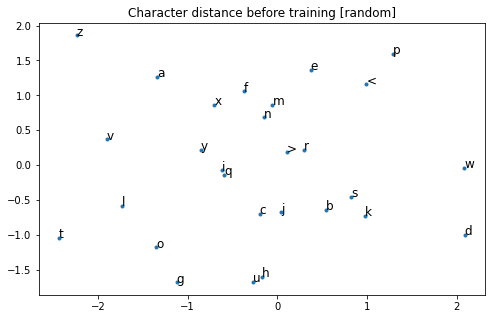

In [15]:
plt.figure(figsize=(8, 5))
plt.scatter(embeddings[:, 0], embeddings[:, 1], marker='.')
for i in range(28):
    chr_ = number_to_chr[i]
    embd = embeddings[i]
    plt.text(embd[0], embd[1], chr_, fontdict={"size":12})
    
plt.title("Character distance before training [random]");

## ♏ Accessing the embeddings
Here, Andrej goes ahead one step further to demonstrate 2 ways to access the embeddings.
1. Just use indexing
2. Matrix multiplication

Now, the 2nd way we didn't use in the makemore with bigram, but that just helped us to pluck out the weights for *that* character where the one hot encoding had `1`. 

Here, instead of going for that stuff, let's simple use the index because at the EOD, what matters is how do we access the embeddings. Allow me to skip that process.

## How do we prepare the data?
We will be sending `3` characters at the time. Thus, there will be `2 + 2 + 2 = 6` float will be sent at the time. Because we have `2` dimension for the embedding per character.

Let's take the example of first `<<<` → `e` datapoint.

In [16]:
# because < has the index 0
embeddings[[0, 0, 0]]

tensor([[0.9918, 1.1556],
        [0.9918, 1.1556],
        [0.9918, 1.1556]])

👉 But to pass it **at once** we will need to flatten it out.

In [17]:
# Re-shapping the tensor so that this example can be sent at once
embeddings[[0, 0, 0]].view((-1, 6))

tensor([[0.9918, 1.1556, 0.9918, 1.1556, 0.9918, 1.1556]])

___
> ⚠ Numpy has: `array.reshape` method to do the same.
___

Simple indexing, okay. <br>
**But** for whole data `X`?

In [18]:
X.shape

torch.Size([32, 3])

It has `32` character *sets* (of 3 characters each). So, we will need some logic to **automate** the indexing.

In [19]:
embeddings[X]

tensor([[[ 0.9918,  1.1556],
         [ 0.9918,  1.1556],
         [ 0.9918,  1.1556]],

        [[ 0.9918,  1.1556],
         [ 0.9918,  1.1556],
         [ 0.3734,  1.3685]],

        [[ 0.9918,  1.1556],
         [ 0.3734,  1.3685],
         [-0.0547,  0.8624]],

        [[ 0.3734,  1.3685],
         [-0.0547,  0.8624],
         [-0.0547,  0.8624]],

        [[-0.0547,  0.8624],
         [-0.0547,  0.8624],
         [-1.3392,  1.2606]],

        [[ 0.9918,  1.1556],
         [ 0.9918,  1.1556],
         [ 0.9918,  1.1556]],

        [[ 0.9918,  1.1556],
         [ 0.9918,  1.1556],
         [-1.3502, -1.1788]],

        [[ 0.9918,  1.1556],
         [-1.3502, -1.1788],
         [-1.7353, -0.5881]],

        [[-1.3502, -1.1788],
         [-1.7353, -0.5881],
         [-0.6210, -0.0761]],

        [[-1.7353, -0.5881],
         [-0.6210, -0.0761],
         [-1.8985,  0.3699]],

        [[-0.6210, -0.0761],
         [-1.8985,  0.3699],
         [-0.6210, -0.0761]],

        [[-1.8985,  0

This one is correct, I have tested it 😉

In [20]:
embeddings[X].shape

torch.Size([32, 3, 2])

In [21]:
# Reshaping
embeddings[X].view(-1, 6)

tensor([[ 0.9918,  1.1556,  0.9918,  1.1556,  0.9918,  1.1556],
        [ 0.9918,  1.1556,  0.9918,  1.1556,  0.3734,  1.3685],
        [ 0.9918,  1.1556,  0.3734,  1.3685, -0.0547,  0.8624],
        [ 0.3734,  1.3685, -0.0547,  0.8624, -0.0547,  0.8624],
        [-0.0547,  0.8624, -0.0547,  0.8624, -1.3392,  1.2606],
        [ 0.9918,  1.1556,  0.9918,  1.1556,  0.9918,  1.1556],
        [ 0.9918,  1.1556,  0.9918,  1.1556, -1.3502, -1.1788],
        [ 0.9918,  1.1556, -1.3502, -1.1788, -1.7353, -0.5881],
        [-1.3502, -1.1788, -1.7353, -0.5881, -0.6210, -0.0761],
        [-1.7353, -0.5881, -0.6210, -0.0761, -1.8985,  0.3699],
        [-0.6210, -0.0761, -1.8985,  0.3699, -0.6210, -0.0761],
        [-1.8985,  0.3699, -0.6210, -0.0761, -1.3392,  1.2606],
        [ 0.9918,  1.1556,  0.9918,  1.1556,  0.9918,  1.1556],
        [ 0.9918,  1.1556,  0.9918,  1.1556, -1.3392,  1.2606],
        [ 0.9918,  1.1556, -1.3392,  1.2606, -1.8985,  0.3699],
        [-1.3392,  1.2606, -1.8985,  0.3

So, now **each row** from above will be passed through the NN one by one and we will then keep monitoring for the loss.

# ⛏ Training time!

Have a look at this structure.

<img src="./Images/NN_Diagram.png" height=500 width=600>

The network is of `2` layers in total.
1. The first one has several nodes which has input of `2 + 2 + 2 = 6` for each node.
2. It outputs some value by **applying `tanh`** activation function.
3. At the last we have the second *output* layer which has the shape of `28` nodes which is fixed because we will predict the next token.

> The **only difference** between the NN used in the last notebook is that, this time the NN has an *extra* layer which can learn some more patterns in the data. Otherwise the last *output* layer is exactly the same as in the previous notebook 😊



### 🏋️‍♂️ We need to initialize the weights

### `1.` First layer

In [22]:
# W1 for the data + first layer (tanh)
W1 = torch.randn((6, 100), generator=generator)
b1 = torch.randn(100, generator=generator)

Why `(6, 100)`?
```python
W1 = torch.randn((6, 100))

# 6 = Number if input data dimension 
# 100 = Number of nodes in that layer
```

So, final number of weights will be `600` in that layer because we are creating a **pure** dance NN. Each node out of 100 nodes is connected to all 6 *nodes* of the data. So, total weights will be 600.

In [23]:
W1.shape

torch.Size([6, 100])

### `2.` Last layer *(output)*

In [24]:
# W2
W2 = torch.randn((100, 28), generator=generator)
b2 = torch.randn(28, generator=generator)

## 👼 The forward pass dry run

### Data @ First Layer

In [25]:
# Calculate the values for the first layer + data

# shape = (32, 6) @ (6, 100)
_1 = embeddings[X].view(-1, 6) @ W1
_1.shape

torch.Size([32, 100])

Cool!
> This means there are: *100 output tensors for all 32 characters in this tiny training data of 5 names*.

Next:
- We will add the bias `b1`
- Apply the activation function `tanh`


In [26]:
_2 = torch.tanh(_1 + b1)
_2.shape

torch.Size([32, 100])

**Great!** This, whole step could be done in the single step like below and that what we will use from now on.

In [27]:
h = torch.tanh(embeddings[X].view(-1, 6) @ W1 + b1)
h

tensor([[ 0.7612,  0.9915,  0.0935,  ...,  0.9641,  0.0485,  0.9986],
        [ 0.6771,  0.9970,  0.2830,  ...,  0.9745, -0.4415,  0.9984],
        [ 0.6972,  0.9918,  0.9539,  ...,  0.9741, -0.8383,  0.9973],
        ...,
        [-0.9929,  0.9185,  0.3388,  ...,  0.6425, -0.9741,  0.8049],
        [ 0.9767,  0.9967,  0.4864,  ...,  0.9987,  0.8590,  0.7965],
        [-0.9993, -0.9389, -0.9957,  ...,  0.8343, -0.9996, -0.9874]])

### First Layer @ Output Layer

In [28]:
# shape = (32, 100) @ (100, 28)
logits = h @ W2 + b2
logits.shape

torch.Size([32, 28])

> This means: *For all 32 sets of 3 character, the predicted logits are in the shape of 28.*

### 🔄 Conversion of logits into probability

In [29]:
# Just as followed in the last book
counts = logits.exp() # to get the "fake" counts
prob = counts / counts.sum(1, keepdims=True)

### 📉 Calculating the loss

In [30]:
# Again, just as before
loss = prob[range(X.shape[0]), y]
loss

tensor([2.9857e-14, 1.0155e-13, 5.0859e-12, 2.1538e-09, 1.8265e-07, 3.6388e-15,
        7.4642e-03, 2.0648e-07, 3.7912e-02, 1.6653e-05, 3.4287e-08, 1.0728e-06,
        2.9255e-09, 8.3277e-11, 9.8566e-04, 4.2593e-06, 1.4135e-12, 1.5755e-14,
        4.8950e-09, 3.8370e-10, 3.4157e-14, 1.2417e-10, 9.4124e-01, 4.9344e-04,
        8.4881e-06, 1.1709e-12, 1.2482e-08, 2.3180e-10, 1.8247e-05, 1.8984e-07,
        4.7189e-03, 7.2453e-06])

> Which is, *from all probability, for each 32 character sets, we have plucked out the "expected" character's probability `y`.*

In [31]:
# Not done still... 
loss = -loss.log().mean()
loss

tensor(17.7475)

Finally we have a single number which can be optimized.

# 🔥 Boom Boom 🔥

Have you ever tried to read some paper and come across the loss function called **"binary cross entropy loss"**? Seriously that makes one feel anxious, worried, stressful... 

Even try ChatGPT for an instance:

<img src="./Images/binary-c-entropy.png">

Then you go to wikipedia:

<img src="./Images/wiki.png" width=400 height=600>

And... you loose all hope.

### 🤨 Okay, why to bring up now?
It really gave me the roller coaster emotions, when I came to know about "binary cross entropy" is what we have just done. 😮

> *It is just the conversion of `logits → exp → probability → log → negation → mean = binary-cross-entropy`.*

**In torch, there is the single function call** which does all these in the single line - ***and faster*** - because it doesn't store the intermediary steps like *log*, *mean*, *exp* etc. 

In [32]:
from torch.nn.functional import cross_entropy

In [33]:
# The final output of the NN, okay?
logits.shape

torch.Size([32, 28])

In [34]:
# The target
y.shape

torch.Size([32])

In [35]:
# Exactly the same! 😍✨ 
cross_entropy(logits, y)

tensor(17.7475)

Better to use it instead 😉

# 🚂 Training. Really. Promise.

In [36]:
### MAKING THE DATASET ###
block_size = 3
sot = chr_to_number["<"]

X = []
y = []

for name in names[:5]: # Again, for 5 names for now.
    window_chars = [sot] * block_size
    name = name + ">" # removed "<" from the start of the name because added before
    
    for ch in name:
        _3chars = ''.join(
            list(
                map(lambda x:number_to_chr[x], window_chars)
            )) # just converted [0, 0, 0] → [<, <, <] → <<<
        ch_index = chr_to_number[ch]
        
        X.append(window_chars)
        y.append(ch_index)
        
        # we will keep updating the last index and shift the ones before that
        # you can use the np.roll() function here as well.
        window_chars = window_chars[1:] + [ch_index]

X = torch.tensor(X)
y = torch.tensor(y)

In [37]:
X.shape, y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [38]:
# The same `embeddings`
embeddings

tensor([[ 0.9918,  1.1556],
        [ 0.1089,  0.1830],
        [-1.3392,  1.2606],
        [ 0.5458, -0.6414],
        [-0.1967, -0.7047],
        [ 2.0866, -1.0059],
        [ 0.3734,  1.3685],
        [-0.3765,  1.0569],
        [-1.1213, -1.6820],
        [-0.1687, -1.6064],
        [-0.6210, -0.0761],
        [ 0.0389, -0.6792],
        [ 0.9774, -0.7255],
        [-1.7353, -0.5881],
        [-0.0547,  0.8624],
        [-0.1494,  0.6852],
        [-1.3502, -1.1788],
        [ 1.2902,  1.5954],
        [-0.5923, -0.1446],
        [ 0.2941,  0.2218],
        [ 0.8183, -0.4591],
        [-2.4333, -1.0451],
        [-0.2752, -1.6687],
        [-1.8985,  0.3699],
        [ 2.0820, -0.0420],
        [-0.7028,  0.8669],
        [-0.8526,  0.2169],
        [-2.2359,  1.8599]])

In [39]:
generator = torch.Generator().manual_seed(42)
W1 = torch.randn((6, 100), generator=generator, requires_grad=True)
b1 = torch.randn(100, generator=generator, requires_grad=True)

W2 = torch.randn((100, 28), generator=generator, requires_grad=True)
b2 = torch.randn(28, generator=generator, requires_grad=True)

In [40]:
parameters = [embeddings, W1, b1, W2, b2]

In [41]:
sum(p.nelement() for p in parameters)

3584

Alright? Total these many weights are there. **Yes,** we will take the **embeddings** as the weights here. Because that will act as our first layer.

#### But, `embeddings` doesn't have the `reuiqres_grad=True`
So, we will update it.

In [42]:
embeddings.requires_grad = True

### All set to train.

In [43]:
epochs = 10
for i in range(epochs):
    # 1️⃣ Forward pass
    emb = embeddings[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # first layer
    logits = h @ W2 + b2 # second layer
    loss = cross_entropy(logits, y)
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = 0.1
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    
    print(f"[{i}] Loss: {loss.item()}")

[0] Loss: 17.747495651245117
[1] Loss: 14.87502384185791
[2] Loss: 12.944549560546875
[3] Loss: 10.998205184936523
[4] Loss: 9.523370742797852
[5] Loss: 8.687643051147461
[6] Loss: 7.806678771972656
[7] Loss: 6.521985054016113
[8] Loss: 6.093925952911377
[9] Loss: 5.54010009765625


Wow! Cool! Now, let's do this for **whole dataset**. Because for just 5 names, it is way too easy for the NN to learn. So, it will overfit and actually **remembers** those names.

## 🌎 For whole dataset

In [45]:
block_size = 3
sot = chr_to_number["<"]

X = []
y = []

for name in names: #FOR ALL NAMES
    window_chars = [sot] * block_size
    name = name + ">" 
    
    for ch in name:
        _3chars = ''.join(
            list(
                map(lambda x:number_to_chr[x], window_chars)
            )) 
        ch_index = chr_to_number[ch]
        
        X.append(window_chars)
        y.append(ch_index)
        window_chars = window_chars[1:] + [ch_index]

X = torch.tensor(X)
y = torch.tensor(y)

In [46]:
X.shape, y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [47]:
# The same `embeddings`
# They have changed, because of the last training. But still we will use it.
embeddings

tensor([[ 0.2803,  0.1146],
        [ 0.1089,  0.1830],
        [-1.1470,  1.1857],
        [ 0.9748, -0.4756],
        [-0.1967, -0.7047],
        [ 2.0866, -1.0059],
        [ 0.2622,  0.9332],
        [-0.3765,  1.0569],
        [-1.1213, -1.6820],
        [-0.0872, -1.9114],
        [-0.7489,  0.0975],
        [ 0.0389, -0.6792],
        [ 0.9774, -0.7255],
        [-1.7160, -0.5941],
        [-0.3791,  0.6850],
        [-0.1494,  0.6852],
        [-1.3895, -1.2126],
        [ 1.3950,  1.4033],
        [-0.5923, -0.1446],
        [ 0.2941,  0.2218],
        [ 0.7794, -0.2856],
        [-2.4333, -1.0451],
        [-0.2752, -1.6687],
        [-1.9082,  0.2821],
        [ 2.0820, -0.0420],
        [-0.7028,  0.8669],
        [-0.8526,  0.2169],
        [-2.2359,  1.8599]], requires_grad=True)

In [48]:
generator = torch.Generator().manual_seed(42)
W1 = torch.randn((6, 100), generator=generator, requires_grad=True)
b1 = torch.randn(100, generator=generator, requires_grad=True)

W2 = torch.randn((100, 28), generator=generator, requires_grad=True)
b2 = torch.randn(28, generator=generator, requires_grad=True)

parameters = [embeddings, W1, b1, W2, b2]

In [56]:
epochs = 10
for i in range(epochs):
    # 1️⃣ Forward pass
    emb = embeddings[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # first layer
    logits = h @ W2 + b2 # second layer
    loss = cross_entropy(logits, y)
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = 0.3 # [Started with 0.5 then changed to 0.3, 0.2]
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    
    print(f"[{i}] Loss: {loss.item()}")

[0] Loss: 3.148758888244629
[1] Loss: 3.0787291526794434
[2] Loss: 3.096921920776367
[3] Loss: 3.105207920074463
[4] Loss: 3.1489291191101074
[5] Loss: 3.072467088699341
[6] Loss: 3.073084592819214
[7] Loss: 3.086663007736206
[8] Loss: 3.131025791168213
[9] Loss: 3.044574499130249


Alright, now we have something really good loss here. After 6-7 training loops of 10 epochs, we have this loss.

# 📸 A snapshot of characters
Finally now, we are **ready** to see how and which characters are similar and come together. *("similar" isn't the right word to use when talking about the characters)*.

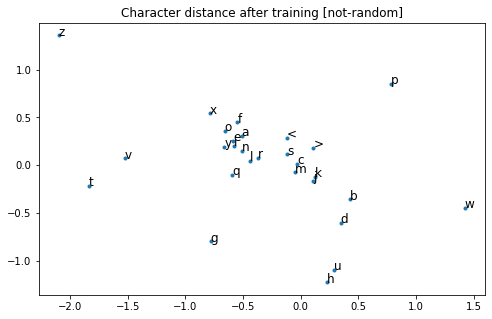

In [55]:
plt.figure(figsize=(8, 5))
plt.scatter(embeddings[:, 0].detach().numpy(), 
            embeddings[:, 1].detach().numpy(), marker='.')

for i in range(28):
    chr_ = number_to_chr[i]
    embd = embeddings[i]
    plt.text(embd[0], embd[1], chr_, fontdict={"size":12})
    
plt.title("Character distance after training [not-random]");

**Interesting!**

- We have the characters like `a`, `c`, `n`, `f` which are similar and often come together
- While the `<` and `>` are the farthest!
- `<` and `b` are also nearby with `q` and `d`.

👉 Of course, this chart of characters isn't that much interpretable enough than what we would have done **for the words**. That will be much more interesting to see!

# 📦 Batching!
▶ Whole flow is like *(currently)*: 
- Give all `228146` sets of 3 to the network
- Predict their next token (all 228146)
- Compare with the expected
- Calculate the loss and then do the back prop.

**Suppose** instead of this 228146 training only, have billion, even trillion of data? Which is the reality of the GPT-3 and other LLMs. They have been trained on trillions of tokens. 

Doing this, on all dataset for multiple epochs will take much much longer to compute. *(In the GPT-3 type of LLMs, the epochs are not this crazy 10, 100 they are in a smaller number 😉)*.

So, we will perform the training in **batches**.

> **NOTE**: What Andrej shows in his [clip](https://youtube.com/clip/UgkxMv-qyfYde5ADR_IZToPBbYuHTdzKmANa) is the **mini-batch** approach. It is where **we randomly** select some `n` rows from the data `X` and use those only in the training. <br><br> While another approach is **not to use rows at random** but partition the data in `n` chunks, and use them for training. For each partition we will perform the backprop.

But, for this lecture, let's focus on the **mini-batch** approach ✌

▶ Whole flow *will* be like: 
- From all `228146` sets of 3 training data, sample `n` rows and give to the network.
- Predict their next token (all `n` samples)
- Compare with the expected
- Calculate the loss and then do the back prop.

In [59]:
generator = torch.Generator().manual_seed(42)

# Starting with the fresh embeddings 😏
embeddings = torch.randn((28, 2), generator=generator, requires_grad=True)
W1 = torch.randn((6, 100), generator=generator, requires_grad=True)
b1 = torch.randn(100, generator=generator, requires_grad=True)

W2 = torch.randn((100, 28), generator=generator, requires_grad=True)
b2 = torch.randn(28, generator=generator, requires_grad=True)

parameters = [embeddings, W1, b1, W2, b2]

In [60]:
losses = []

In [103]:
batch_size = 32 # just any number - but smaller than 228146 ;)
epochs = 10

for i in range(epochs):
    # Data Sampling
    sample_idx = torch.randint(0, X.shape[0], (32,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[X[sample_idx]] ### CHANGE HERE ###
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, y[sample_idx]) ### CHANGE HERE ###
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = 0.02 
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    
    print(f"[{i}] Loss: {loss.item()}")
    losses.append(loss.item())

[0] Loss: 2.618518590927124
[1] Loss: 2.6600446701049805
[2] Loss: 2.485013723373413
[3] Loss: 2.722689628601074
[4] Loss: 2.399287462234497
[5] Loss: 2.7644758224487305
[6] Loss: 2.677192449569702
[7] Loss: 2.4680988788604736
[8] Loss: 2.918463706970215
[9] Loss: 2.615480422973633


After so many re-reuns, we have this loss.

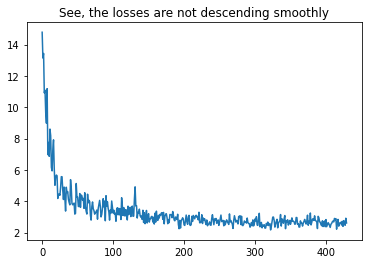

In [104]:
plt.plot(losses)
plt.title("See, the losses are not descending smoothly");

**But** the process was really quick! Once more, let's check the embeddings.

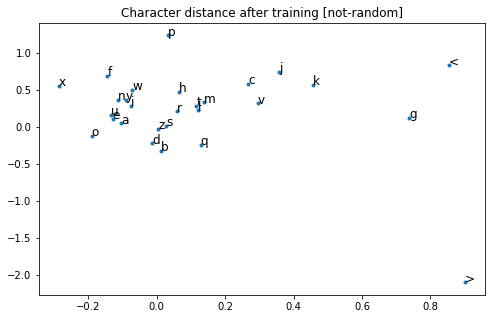

In [105]:
plt.figure(figsize=(8, 5))
plt.scatter(embeddings[:, 0].detach().numpy(), 
            embeddings[:, 1].detach().numpy(), marker='.')

for i in range(28):
    chr_ = number_to_chr[i]
    embd = embeddings[i]
    plt.text(embd[0], embd[1], chr_, fontdict={"size":12})
    
plt.title("Character distance after training [not-random]");

Alright, this time... we have a different picture. But still the model has managed to **seperate** the special tokens!

In [106]:
# And on WHOLE dataset? What is the loss? Should we stop now?
emb = embeddings[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 
loss = cross_entropy(logits, y)
loss

tensor(2.6728, grad_fn=<NllLossBackward0>)

It is `3` ish... loss.

## When to know it is enough?
Here Andrej shows one of the ways that can be used — try all of them and see what works best.

1. **Define what is the lowest learning rate**: the one which doesn't improve the loss *(very very tiny improvement)*.
2. **Define what is the high learning rate**:  the one which blasts the loss, sometime the loss is too low while too high other times
3. **Get different learning rates**: between these low and high intervals
4. **Try all of them**: so that we get some "elbow" chart.

> I belive his trials for finding the optimal learning rate is very well explained in [this](https://youtube.com/clip/UgkxQ2H09n2AK-tKvpV4o9A5Y_EvPRAU4yEC) clip. However, we will try that as well in our code.

In [111]:
generator = torch.Generator().manual_seed(42)

# Starting with the fresh embeddings 😏
embeddings = torch.randn((28, 2), generator=generator, requires_grad=True)
W1 = torch.randn((6, 100), generator=generator, requires_grad=True)
b1 = torch.randn(100, generator=generator, requires_grad=True)

W2 = torch.randn((100, 28), generator=generator, requires_grad=True)
b2 = torch.randn(28, generator=generator, requires_grad=True)

parameters = [embeddings, W1, b1, W2, b2]

In [112]:
batch_size = 32 # just any number - but smaller than 228146 ;)
epochs = 50

for i in range(epochs):
    # Data Sampling
    sample_idx = torch.randint(0, X.shape[0], (32,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[X[sample_idx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, y[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = 1 # Too low or too high change here.
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    
    print(f"[{i}] Loss: {loss.item()}")

[0] Loss: 14.782527923583984
[1] Loss: 13.998558044433594
[2] Loss: 12.48405647277832
[3] Loss: 8.488659858703613
[4] Loss: 8.61085033416748
[5] Loss: 9.467575073242188
[6] Loss: 12.204753875732422
[7] Loss: 11.550914764404297
[8] Loss: 10.060081481933594
[9] Loss: 12.084990501403809
[10] Loss: 14.216203689575195
[11] Loss: 11.00980281829834
[12] Loss: 10.187737464904785
[13] Loss: 10.34494400024414
[14] Loss: 7.457319259643555
[15] Loss: 10.349586486816406
[16] Loss: 11.416388511657715
[17] Loss: 9.988653182983398
[18] Loss: 10.212839126586914
[19] Loss: 9.120953559875488
[20] Loss: 10.300275802612305
[21] Loss: 8.229862213134766
[22] Loss: 7.1749348640441895
[23] Loss: 7.8229899406433105
[24] Loss: 8.310338020324707
[25] Loss: 9.062294960021973
[26] Loss: 9.73953914642334
[27] Loss: 12.004658699035645
[28] Loss: 14.401727676391602
[29] Loss: 9.142486572265625
[30] Loss: 8.813543319702148
[31] Loss: 9.314979553222656
[32] Loss: 9.155377388000488
[33] Loss: 7.9735822677612305
[34] Loss

Low learning rate = `0.001` and high is `1`. So we will get *linearly* spaced numbers which represent the learning rates.

In [120]:
linear_learning_rates = torch.linspace(0.001, 1, 1000)
linear_learning_rates[:5]

tensor([0.0010, 0.0020, 0.0030, 0.0040, 0.0050])

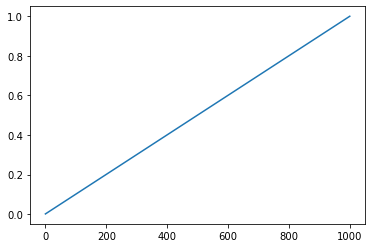

In [122]:
plt.plot(linear_learning_rates);

___
> ⚠ **Numpy alternative:** `np.linspace(0.001, 1, 1000)`
___

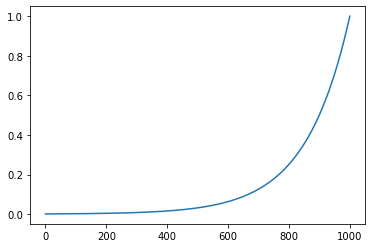

In [123]:
exp_learning_rates = torch.linspace(-3, 0, 1000)
exp_learning_rates = 10**exp_learning_rates
plt.plot(exp_learning_rates);

> Using the **exp** learning rates will benefit because the magnitude of them will rise slowly and we will be able to see how progress we are making on each step.

In [130]:
generator = torch.Generator().manual_seed(42)

# Starting with the fresh embeddings 😏
embeddings = torch.randn((28, 2), generator=generator, requires_grad=True)
W1 = torch.randn((6, 100), generator=generator, requires_grad=True)
b1 = torch.randn(100, generator=generator, requires_grad=True)

W2 = torch.randn((100, 28), generator=generator, requires_grad=True)
b2 = torch.randn(28, generator=generator, requires_grad=True)

parameters = [embeddings, W1, b1, W2, b2]

In [131]:
batch_size = 32 
epochs = 1000 # this should be the sames as total learning rates defined :)
losses = []

for i in range(epochs):
    # Data Sampling
    sample_idx = torch.randint(0, X.shape[0], (32,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[X[sample_idx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, y[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = exp_learning_rates[i]
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item())

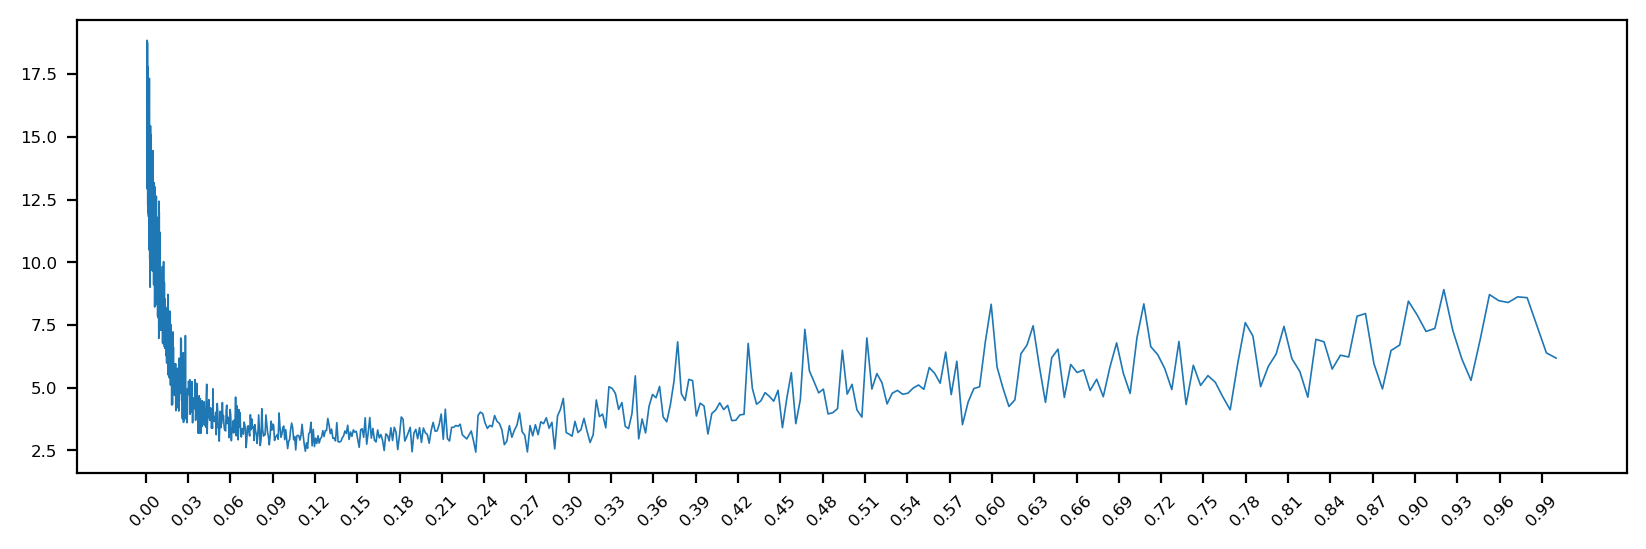

In [164]:
plt.figure(figsize=(10, 3), dpi=200)
plt.plot(exp_learning_rates, losses, lw=.6)
plt.xticks(np.arange(0.0, 1.0, 0.03), rotation=45, fontsize=6)
plt.yticks(fontsize=6);

It seems to be a good learning rate is between `0.01` to `0.03`. 

### Assuming 0.01 is good one...

In [165]:
batch_size = 32 
epochs = 50_000
losses = []

for i in range(epochs):
    # Data Sampling
    sample_idx = torch.randint(0, X.shape[0], (32,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[X[sample_idx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, y[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item())

Went too far for `50_000` epochs!

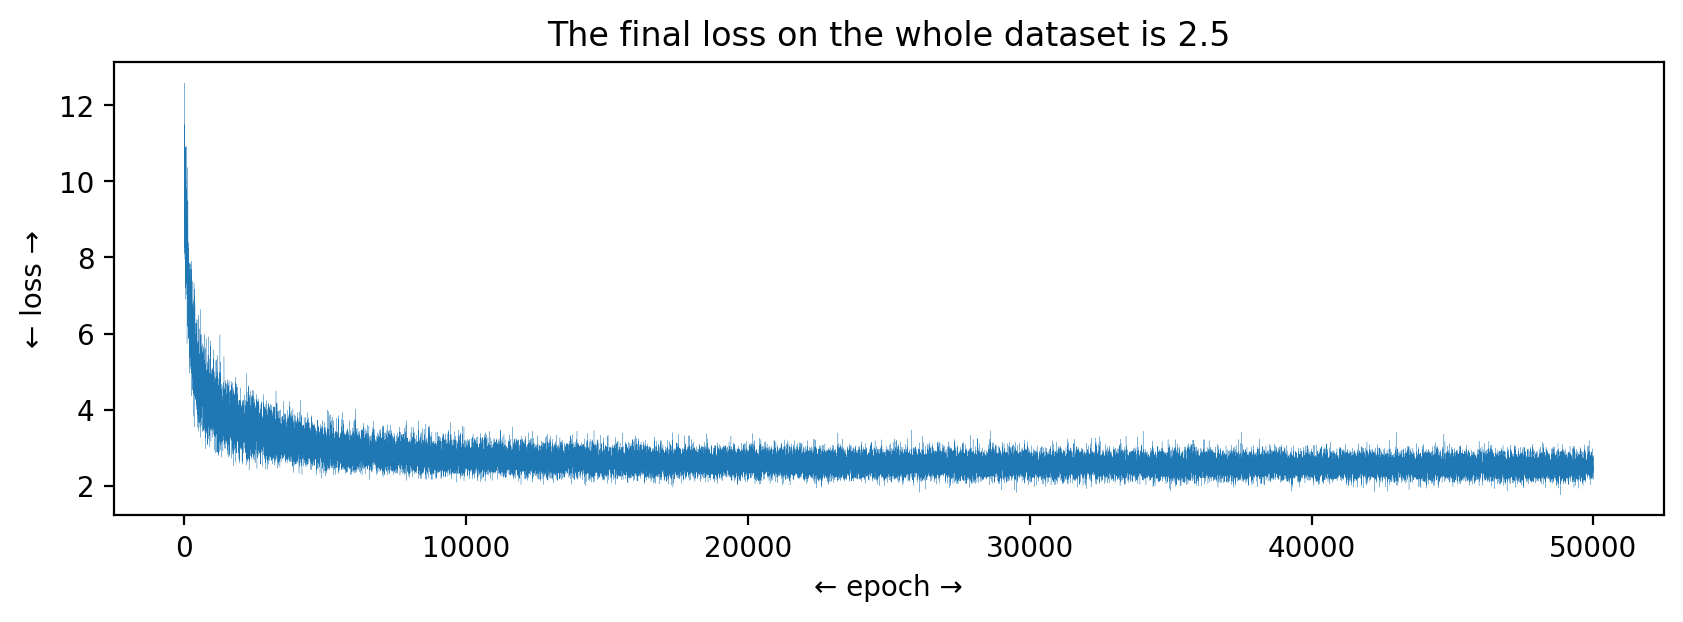

In [174]:
plt.figure(figsize=(10, 3), dpi=200)
plt.plot(losses, lw=0.1)


# And on WHOLE dataset? What is the loss? Should we stop now?
emb = embeddings[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 
final_loss = cross_entropy(logits, y)
final_loss

plt.title(f"The final loss on the whole dataset is {round(final_loss.item(), 3)}")
plt.xlabel("← epoch →")
plt.ylabel("← loss →");

ALright, the loss is low `2.499`.

# 🪓 Recall Train - Test - Split!?

> Please access "the trouble with" using whole dataset [in this clip](https://youtube.com/clip/Ugkx2lP1nJzI7jhfPA7pEvmnNbLSwHXIrfHF).

We will start by splitting the dataset directly :)

In [175]:
def build_dataset(shuffled_names):
    block_size = 3
    sot = chr_to_number["<"]

    X = []
    y = []

    for name in shuffled_names: #FOR ALL NAMES
        window_chars = [sot] * block_size
        name = name + ">" 

        for ch in name:
            _3chars = ''.join(
                list(
                    map(lambda x:number_to_chr[x], window_chars)
                )) 
            ch_index = chr_to_number[ch]

            X.append(window_chars)
            y.append(ch_index)
            window_chars = window_chars[1:] + [ch_index]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

In [183]:
import random
random.seed(42)
random.shuffle(names) # In-place shuffling. No longer first word will be "emma"

In [184]:
names[:5]

['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']

In [187]:
train_idx = int(0.8 * len(names)) # 80%
val_idx = int(0.9 * len(names)) # 90% - 80% = 10%

train_idx, val_idx

(25626, 28829)

In [188]:
Xtrain, ytrain = build_dataset(names[:train_idx])
Xval, yval = build_dataset(names[train_idx:val_idx])
Xtest, ytest = build_dataset(names[val_idx:])

In [201]:
print(f"* {Xtrain.shape = }\n* {Xval.shape = }\n* {Xtest.shape = }")

* Xtrain.shape = torch.Size([182625, 3])
* Xval.shape = torch.Size([22655, 3])
* Xtest.shape = torch.Size([22866, 3])


# 👷‍♂️Training with Train-Test-Val split!

### 1️⃣ Train using `Xtrain`

In [225]:
generator = torch.Generator().manual_seed(42)

# Starting with the fresh embeddings 😏
embeddings = torch.randn((28, 2), generator=generator, requires_grad=True)
W1 = torch.randn((6, 100), generator=generator, requires_grad=True)
b1 = torch.randn(100, generator=generator, requires_grad=True)

W2 = torch.randn((100, 28), generator=generator, requires_grad=True)
b2 = torch.randn(28, generator=generator, requires_grad=True)

parameters = [embeddings, W1, b1, W2, b2]

In [226]:
losses = []

In [230]:
batch_size = 32 
epochs = 10_000


for i in range(epochs):
    # Data Sampling (FROM XTRAIN ONLY)
    sample_idx = torch.randint(0, Xtrain.shape[0], (32,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item())

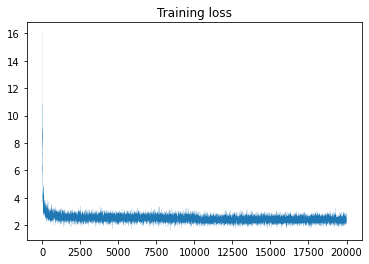

In [231]:
plt.plot(losses, lw=0.1)
plt.title("Training loss");

In [232]:
losses[-1]

2.2008938789367676

### 2️⃣ Evaluate using `Xval`

In [233]:
emb = embeddings[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 
final_loss = cross_entropy(logits, yval)
final_loss

tensor(2.3927, grad_fn=<NllLossBackward0>)

Good!

## Woa, woa, woa!
We are **underfitting**!?

The losses on the training and dev sets are equal. Andrej gives the reason that "the model isn't able to purely memorize" the data. So we can expect more from the model by **increasing** the size of the model.

*(At this point, I am not sure why to increase the size because model seems to do a decent job. But let's get along with the lecture)*.

### 1️⃣ Train using `Xtrain` - Changed model architecture

In [240]:
generator = torch.Generator().manual_seed(42)

# Starting with the fresh embeddings 😏
embeddings = torch.randn((28, 2), generator=generator, requires_grad=True)
W1 = torch.randn((6, 300), generator=generator, requires_grad=True) # Changed the output params 300
b1 = torch.randn(300, generator=generator, requires_grad=True) # Here as well

W2 = torch.randn((300, 28), generator=generator, requires_grad=True) # Here as well
b2 = torch.randn(28, generator=generator, requires_grad=True)

parameters = [embeddings, W1, b1, W2, b2]

In [241]:
# Now the model is...
sum(p.nelement() for p in parameters)

10584

We have now `10.5K` parameters in the neural net!

In [242]:
losses = []

In [246]:
batch_size = 32 
epochs = 30_000


for i in range(epochs):
    # Data Sampling (FROM XTRAIN ONLY)
    sample_idx = torch.randint(0, Xtrain.shape[0], (32,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = 0.1
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item())

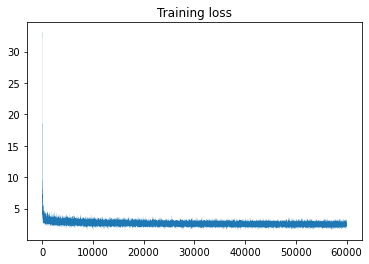

In [247]:
plt.plot(losses, lw=0.1)
plt.title("Training loss");

In [248]:
losses[-1]

2.6395883560180664

### 2️⃣ Evaluate using `Xval`

In [249]:
emb = embeddings[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 
final_loss = cross_entropy(logits, yval)
final_loss

tensor(2.5335, grad_fn=<NllLossBackward0>)

## Hey, before going forward
2 really **helpful** notes given in the lecture **if the performance is not improving**:
1. **Check the mini-batch size**: Because smaller batch will not let the model to learn much, so the loss tends to jagger a and won't converge.
2. **The bottleneck**: We are still playing with the embeddings `2`. That might not be enough for the model to learn.

There can be ***many*** moving parts in the model. That's why we need to understand the hyperparameters and what to touch and what not to. But otherwise **the model** is big enought that **should** overfit the training data!

# 😰 Embeddings are going to get crazy!

In [276]:
generator = torch.Generator().manual_seed(42)

# EMBEDDINGS OF SIZE 10
embeddings = torch.randn((28, 10), generator=generator, requires_grad=True)
W1 = torch.randn((30, 200), generator=generator, requires_grad=True) # Changed the output params 200
b1 = torch.randn(200, generator=generator, requires_grad=True) # Here as well

W2 = torch.randn((200, 28), generator=generator, requires_grad=True) # Here as well
b2 = torch.randn(28, generator=generator, requires_grad=True)

parameters = [embeddings, W1, b1, W2, b2]

In [277]:
# Now the model is...
sum(p.nelement() for p in parameters)

12108

We have now `12K` parameters in the neural net!

In [278]:
losses = []

👉 Since the size of the embeddings is `10`, we will have to change the `emb.view(-1, 6)`  to `emb.view(-1, 30)` for obvious reasons.

In [294]:
batch_size = 32 
epochs = 200_000


for i in range(epochs):
    # Data Sampling (FROM XTRAIN ONLY)
    sample_idx = torch.randint(0, Xtrain.shape[0], (32,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) ### CAREFUL! USE PROPER VIEW. ###
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update
    learning_rate = 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.log10().item()) # for better visualization

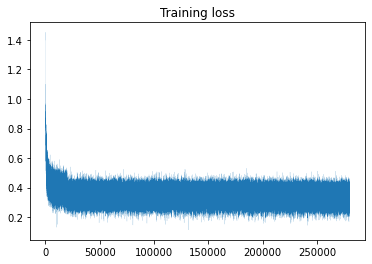

In [295]:
plt.plot(losses, lw=0.1)
plt.title("Training loss");

### 2️⃣ Evaluate using `Xval`

In [297]:
emb = embeddings[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
final_loss = cross_entropy(logits, yval)
final_loss

tensor(2.2037, grad_fn=<NllLossBackward0>)

### 3️⃣ Finally on the test set!?

In [298]:
emb = embeddings[Xtest]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
final_loss = cross_entropy(logits, ytest)
final_loss

tensor(2.2017, grad_fn=<NllLossBackward0>)

Good!

# Making-more! 🎉

In [ ]:
block_size = 3
sot = chr_to_number["<"]

for name in shuffled_names: #FOR ALL NAMES
    window_chars = [sot] * block_size
    name = name + ">" 

    for ch in name:
        _3chars = ''.join(
            list(
                map(lambda x:number_to_chr[x], window_chars)
            )) 
        ch_index = chr_to_number[ch]

        X.append(window_chars)
        y.append(ch_index)
        window_chars = window_chars[1:] + [ch_index]

In [309]:
from torch.nn.functional import softmax

In [310]:
emb = embeddings[[0,0,0]]
h = torch.tanh(emb.view(1, -1) @ W1 + b1)
logits = h @ W2 + b2
probs = softmax(logits, dim=1)

In [314]:
probs

tensor([[1.4356e-05, 3.1706e-06, 1.1582e-01, 4.1477e-02, 5.2057e-02, 5.1377e-02,
         5.7331e-02, 1.2289e-02, 1.9954e-02, 3.4209e-02, 1.6486e-02, 7.6566e-02,
         9.2696e-02, 6.1814e-02, 7.4182e-02, 3.7534e-02, 9.5969e-03, 1.8014e-02,
         2.7535e-03, 4.0450e-02, 5.8364e-02, 4.4855e-02, 2.1251e-03, 1.5514e-02,
         1.0298e-02, 3.8403e-03, 1.8634e-02, 3.1746e-02]],
       grad_fn=<SoftmaxBackward0>)

In [323]:
block_size = 3
sot = chr_to_number["<"]
eot = chr_to_number[">"]
new_names = []

for i in range(20):
    new_name = []
    window_chars = [0] * block_size
    ch_ix = sot
    
    while ch_ix != eot:
        emb = embeddings[window_chars]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = softmax(logits, dim=1)
        
        ch_ix = torch.multinomial(probs, num_samples=1, generator=generator).item()
        ch = number_to_chr[ch_ix]
        new_name.append(ch)
        window_chars = window_chars[1:] + [ch_ix]
    
    new_names.append(''.join(new_name))

In [324]:
new_names

['hia>',
 'kaidestov>',
 'ahmelen>',
 'corhakni>',
 'zhia>',
 'eksisti>',
 'feminlee>',
 'khiane>',
 'zai>',
 'oleann>',
 'nalalainylie>',
 'chriy>',
 'chari>',
 'jamarda>',
 'ashiveleortha>',
 'makbili>',
 'kaybarnie>',
 'eser>',
 'zristabtun>',
 'akenleyah>']

In [329]:
model = dict(
    embeddings=embeddings,
    W1=W1,
    b1=b1,
    W2=W2,
    b2=b2
)

In [330]:
# Storing the model for future use.
import pickle
with open("makemore_mlp.pkl", "wb") as file:
    pickle.dump(model, file)

# Amazing! 🙌
Thankfully we are heading towards a better names! Keep some of them in your mind for your future generation 😉